In [1]:
import process_data as process
import perform_analysis as analyze
import generate_graph as graph
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
# download data from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1310076601 on May 8, 2020
# load statscan covid19 data and format the VALUE column (N = 409,123)
covid19 = pd.read_csv('https://raw.githubusercontent.com/jason-chia/covid19_data_analysis/master/13100766.csv', low_memory=False)
covid19['VALUE'] = covid19['VALUE'].fillna(9)
covid19['VALUE'] = covid19['VALUE'].astype(int)
print('\n')
print('Raw dataset Downloaded from Statistics Canada on May 8, 2020 - 13 Records per COVID-19 Infected Person')
print('(N = 409,123)')
print('\n')
print(covid19.head(15))
print('\n')



Raw dataset Downloaded from Statistics Canada on May 8, 2020 - 13 Records per COVID-19 Infected Person
(N = 409,123)


    Case identifier number                      Case information  VALUE
0                        1    Date case was last updated - month      4
1                        1      Date case was last updated - day     16
2                        1                  Episode date - month      1
3                        1                    Episode date - day     21
4                        1                                Gender      1
5                        1                             Age group      5
6                        1                          Transmission      1
7                        1                       Hospitalization      1
8                        1                   Intensive care unit      2
9                        1                                 Death      2
10                       1      Hospitalization, previous status      1
11             

In [3]:
# transponse the data using the pivot option (N = 31,471)
columns = covid19.columns.tolist()
data = covid19.pivot(index=columns[0], columns=columns[1], values = columns[2]).reset_index().rename_axis(None, axis=1)

In [4]:
# format the dataset including renaming column names, concatenating dates, and reordering variables 
data = process.format_data(data)

In [5]:
# recode the variables
data = process.recode_variable(data)
print('\n')
print('One Row per COVID-19 Infected Person after Data Transposing, Formatting, and Recoding (N = 31,471)')
print('\n')
print(data[['case_id', 'episode_date', 'last_reported_date', 'age_group', 'gender', 'transmission']].head(5))
print('\n')
print(data[['case_id', 'hospitalization', 'p_hospitalization', 'icu', 'p_icu', 'death', 'p_death']].head(5))
print('\n')



One Row per COVID-19 Infected Person after Data Transposing, Formatting, and Recoding (N = 31,471)


   case_id episode_date last_reported_date  age_group  gender  transmission
0        1   2020-01-21         2020-04-16         55       1             1
1        2   2020-01-22         2020-04-07         45       1             1
2        3   2020-01-24         2020-04-22         25       0             1
3        4   2020-01-27         2020-04-07         55       0             1
4        5   2020-01-15         2020-04-07         35       1             1


   case_id  hospitalization  p_hospitalization  icu  p_icu  death  p_death
0        1                1                  1    0      0      0        0
1        2                1                  1    9      9      0        0
2        3                9                  9    0      0      0        0
3        4                1                  1    1      1      0        0
4        5                0                  0    9      9      

In [6]:
# get variable name and description of the dataset
variable = process.get_variable(data)
print('\n')
print('Variable Name and Description')
print('\n')
print(tabulate(variable, variable.columns, tablefmt="github"))
print('\n')



Variable Name and Description


|    | Variable Name      | Variable Description                |
|----|--------------------|-------------------------------------|
|  0 | case_id            | Case Identifier ID                  |
|  1 | episode_date       | Date Case was Confirmed             |
|  2 | last_reported_date | Date Case was Last Updated          |
|  3 | age_group          | Age Group                           |
|  4 | gender             | Gender                              |
|  5 | transmission       | Mode of Transmission                |
|  6 | hospitalization    | Hospitalization Status              |
|  7 | p_hospitalization  | Hospitalization Previous Status     |
|  8 | icu                | Intensive Care Unit Status          |
|  9 | p_icu              | Intensive Care Unit Previous Status |
| 10 | death              | Death Status                        |
| 11 | p_death            | Death Previous Status               |




In [7]:
# define cohort by excluding missing episode_date (N = 30,182)
# define episode_days as the number of days from the earliest date which is Jan 15, 2020
cohort = data[data.episode_date.notnull()]
episode_days = cohort.episode_date - min(cohort['episode_date'].unique())
episode_days = episode_days.astype('timedelta64[D]').astype(int).tolist()
cohort.insert(2, "episode_days", episode_days, True)

In [8]:
# display 2-way frequency tables between (age_group, gender, transmission) and death
freq_tables = analyze.generate_frequency(cohort)
varname = ['Age Group', 'Gender', 'Transmission']
for i in range(0, len(freq_tables)):
    print('\n')    
    print('2-Way Frequency Table: ' + varname[i] +' vs COVID-19 Death Status as of May 8, 2020')
    print('(Excluding Cases with Missing Confirmation Date)\n')
    print(freq_tables[i] + '\n')
    print('\n')



2-Way Frequency Table: Age Group vs COVID-19 Death Status as of May 8, 2020
(Excluding Cases with Missing Confirmation Date)

|         |   Death No |   Death Yes |   Death Unknown |   Total |
|---------|------------|-------------|-----------------|---------|
| 0-19    |        631 |           0 |             738 |    1369 |
| 20-29   |       1757 |           5 |            1803 |    3565 |
| 30-39   |       1898 |           7 |            2266 |    4171 |
| 40-49   |       2048 |          15 |            2670 |    4733 |
| 50-59   |       2453 |          53 |            2421 |    4927 |
| 60-69   |       1833 |         139 |            1685 |    3657 |
| 70-79   |       1043 |         298 |            1106 |    2447 |
| 80+     |       1180 |        1159 |            2592 |    4931 |
| Unknown |        329 |           2 |              51 |     382 |
| Total   |      13172 |        1678 |           15332 |   30182 |





2-Way Frequency Table: Gender vs COVID-19 Death Status as of Ma

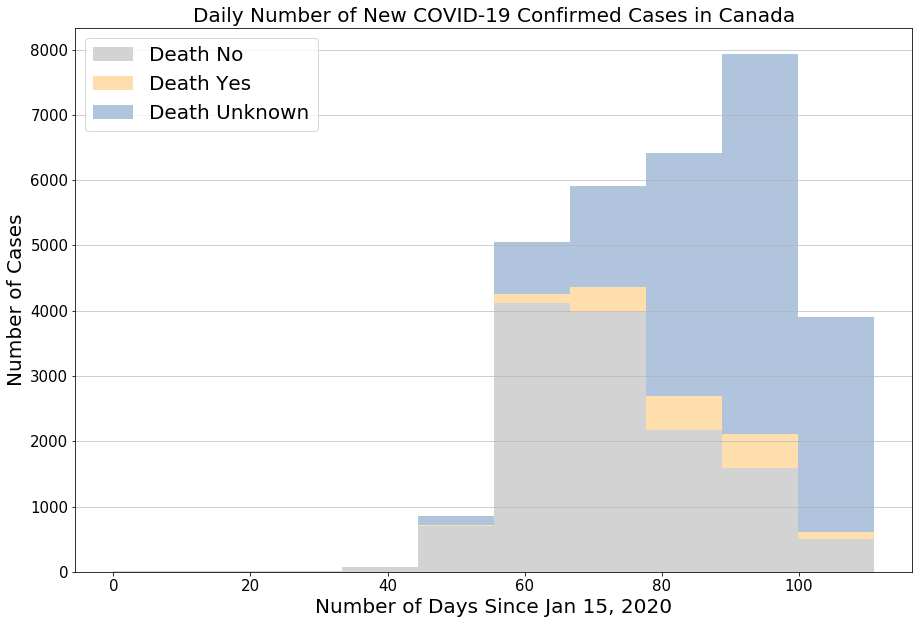

In [9]:
# generate a histgram of the daily number of new cases, stratified by their death status as of May 8, 2020
graph.display_daily_num(cohort)

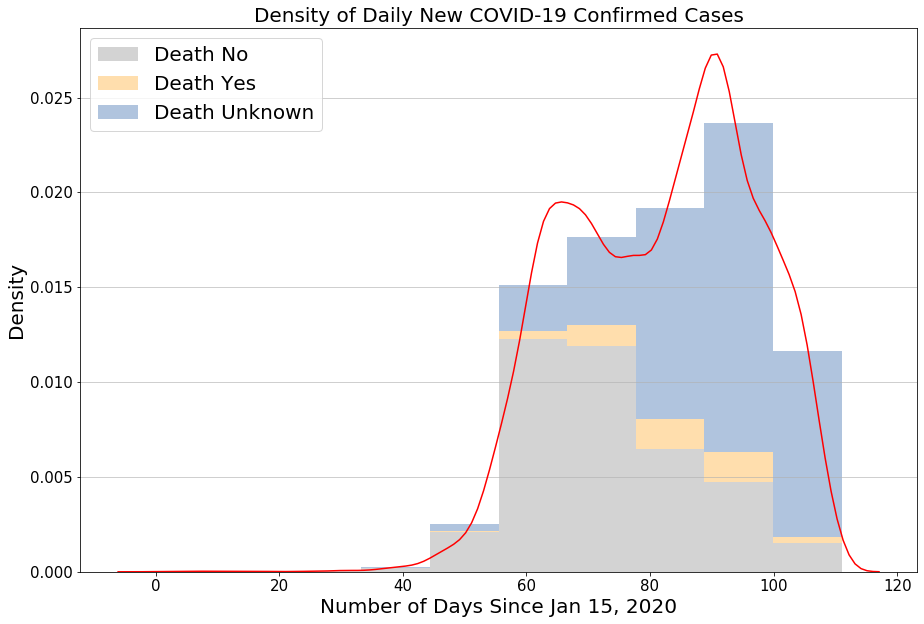

In [10]:
# generate histogram of the density and overlay a curve on top of the density
graph.display_daily_density(cohort)

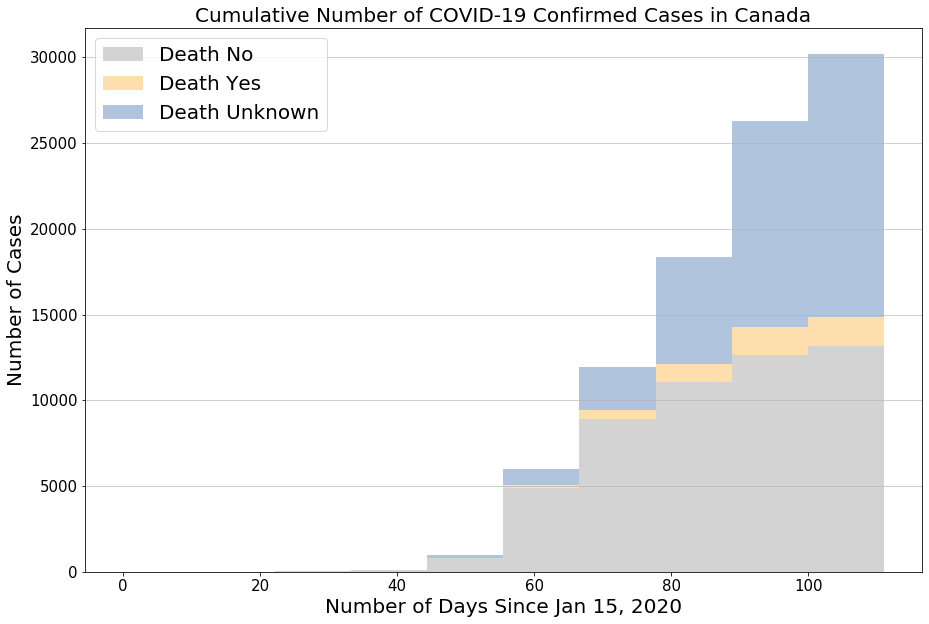

In [11]:
# generate a histgram of the cumulative number of cases, stratified by their death status as of May 8, 2020
graph.display_cumulative_num(cohort)

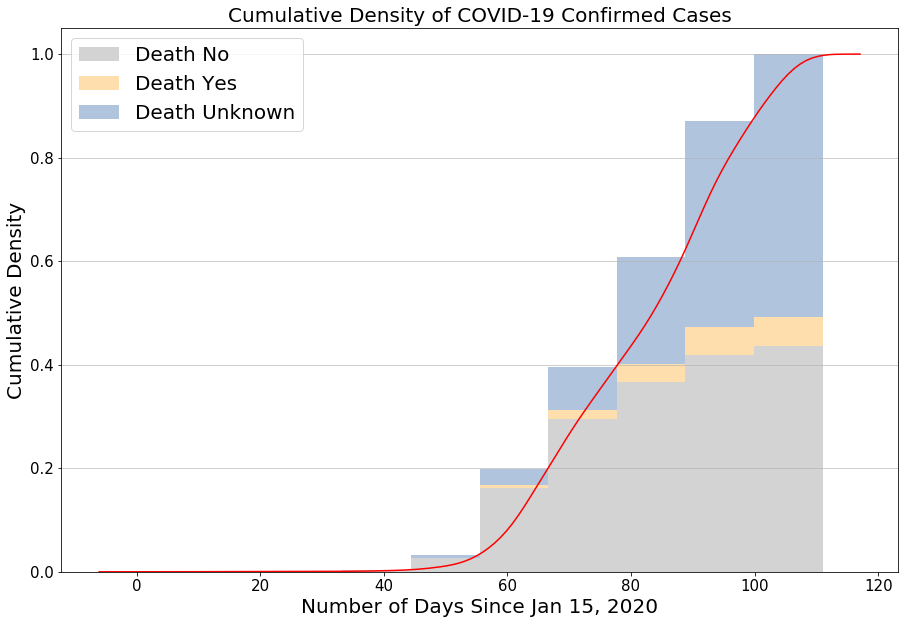

In [12]:
# generate histogram of the cumulative density and overlay a curve on top of the cumulative density
graph.display_cumulative_density(cohort)

In [13]:
# define cohort2 by excluding missing age_group, gender, transmission, and death from cohort (N = 13,214)
# use cohort2 to model the death status (response) by age_group, gender, and transmission (predictors)
# split the dataset into training (2/3) and validation (1/3)
cohort2 = cohort[(cohort.age_group != 99) & (cohort.gender !=9) & (cohort.transmission != 9) & (cohort.death != 9)]
x = cohort2[['age_group', 'gender', 'transmission']]
y = cohort2['death'] 
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=1/3, random_state=1)

In [14]:
# perform chi-square test to see which predictors are dependent on death using the training dataset at alpha = 0.05
# predictors: age_group (8 levels), gender (2 levels), transmission (2 levels)
# response: death (2 levels)
chi2_test = analyze.perform_chi2_test(x_train, y_train, 0.05)
print('\n')    
print('Chi-Sqaure Test between (Age Group, Gender, Mode of Transmission) and COVID-19 Death Status')
print('Using the Training Dataset\n')
print(tabulate(chi2_test, chi2_test.columns, tablefmt="github", floatfmt=".2f"))
print('\n')



Chi-Sqaure Test between (Age Group, Gender, Mode of Transmission) and COVID-19 Death Status
Using the Training Dataset

|    | Predictor Variable   |   Chi-Square |   p-value | significance   |
|----|----------------------|--------------|-----------|----------------|
|  0 | age_group            |      2850.26 |      0.00 | Yes            |
|  1 | gender               |         8.16 |      0.00 | Yes            |
|  2 | transmission         |       247.45 |      0.00 | Yes            |




In [15]:
# perform one additional chi-square test betweeen each age_group vs death (total 8) using the training dataset at alpha=0.05
age_group_dummies = pd.get_dummies(x_train['age_group'])
age_group_dummies.columns = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
chi2_age_group = analyze.perform_chi2_test(age_group_dummies, y_train, 0.05/cohort2['age_group'].nunique())
print('\n')    
print('Chi-Sqaure Test between Each Age Group vs COVID-19 Death Status Using the Training Dataset\n')
print(tabulate(chi2_age_group, chi2_age_group.columns, tablefmt="github", floatfmt=".2f"))
print('\n')



Chi-Sqaure Test between Each Age Group vs COVID-19 Death Status Using the Training Dataset

|    | Predictor Variable   |   Chi-Square |   p-value | significance   |
|----|----------------------|--------------|-----------|----------------|
|  0 | 0-19                 |        46.38 |      0.00 | Yes            |
|  1 | 20-29                |       133.56 |      0.00 | Yes            |
|  2 | 30-39                |       151.78 |      0.00 | Yes            |
|  3 | 40-49                |       154.97 |      0.00 | Yes            |
|  4 | 50-59                |       144.97 |      0.00 | Yes            |
|  5 | 60-69                |        24.12 |      0.00 | Yes            |
|  6 | 70-79                |        68.32 |      0.00 | Yes            |
|  7 | 80+                  |      2584.48 |      0.00 | Yes            |




In [16]:
# fit models to see what attributes of the COVID-19 infected individual is prone to death
# predictors: age_group (8 levels), gender (2 levels), transmission (2 levels)
# response: death (2 levels)
# treat age_group as ordinary/continuous (treating age_group as categorical previously produces the same prediction accuracy)
# define 6 models (chi-square test for gender is not significant in the dataset downloaded on April 30, 2020)
# 1. logistic regression with gender
# 2. logistic regression without gender
# 3. support vector machine with gender
# 4. support vector machine without gender
# 5. naive bayes classifier with gender
# 6. naive bayes classifier without gender
models = []
models.append((LogisticRegression(),['age_group','gender','transmission'], 'Logistic Regression with Gender'))
models.append((LogisticRegression(),['age_group','transmission'], 'Logistic Regression without Gender'))
models.append((SVC(gamma='auto',kernel='rbf'), ['age_group','gender','transmission'], 'Support Vector Machine with Gender'))
models.append((SVC(gamma='auto',kernel='rbf'), ['age_group','transmission'], 'Support Vector Machine without Gender'))
models.append((GaussianNB(), ['age_group','gender','transmission'], 'Naive Bayes Classifier with Gender'))
models.append((GaussianNB(), ['age_group','transmission'], 'Naive Bayes Classifier without Gender'))

In [17]:
# fit the model using the training dataset
selection, classification_tables = analyze.fit_mdoel(models, x_train, y_train, x_validate, y_validate)

In [18]:
# output prediction accuracy for each model using the validation dataset
print('\n')    
print('Prediction Accuracy of Each Model on the Validation Dataset\n')
print(tabulate(selection, selection.columns, tablefmt="github", floatfmt=".4f"))
print('\n')



Prediction Accuracy of Each Model on the Validation Dataset

|    | Model                                 |   Prediction Accuracy |
|----|---------------------------------------|-----------------------|
|  0 | Logistic Regression with Gender       |                0.9006 |
|  1 | Logistic Regression without Gender    |                0.8894 |
|  2 | Support Vector Machine with Gender    |                0.9006 |
|  3 | Support Vector Machine without Gender |                0.8894 |
|  4 | Naive Bayes Classifier with Gender    |                0.8611 |
|  5 | Naive Bayes Classifier without Gender |                0.8611 |




In [19]:
# output the confusion matrix for each model using the validation dataset
for i in range(0, len(models)):
    print('\n')    
    print(models[i][2] + ' on the Validation Dataset\n')
    print(classification_tables[i])
    print('\n')



Logistic Regression with Gender on the Validation Dataset

|                  |   Predicted Death No |   Predicted Death Yes |   Total |
|------------------|----------------------|-----------------------|---------|
| Actual Death No  |                 3869 |                   107 |    3976 |
| Actual Death Yes |                  331 |                    98 |     429 |
| Total            |                 4200 |                   205 |    4405 |




Logistic Regression without Gender on the Validation Dataset

|                  |   Predicted Death No |   Predicted Death Yes |   Total |
|------------------|----------------------|-----------------------|---------|
| Actual Death No  |                 3652 |                   324 |    3976 |
| Actual Death Yes |                  163 |                   266 |     429 |
| Total            |                 3815 |                   590 |    4405 |




Support Vector Machine with Gender on the Validation Dataset

|                  |   Pred

In [20]:
# show logistic regression without gender in greater detail: log(P(death=1)) ~ age_group + transmission
# exclude gender from the model as the model seems to predict the number of actual death better
parameters = analyze.fit_logistic_regression(x_train.drop('gender', axis = 1), y_train, x_validate.drop('gender', axis = 1), y_validate)
print('\n')    
print('Parameter Estimate of the Logistic Regression Model without Gender Using the Training Dataset\n')
print(tabulate(parameters, parameters.columns, tablefmt="github", floatfmt=".4f"))
print('\n')



Parameter Estimate of the Logistic Regression Model without Gender Using the Training Dataset

|    | Variable     |   Coefficient |   Standard Error |   95% Lower |   95% Upper |
|----|--------------|---------------|------------------|-------------|-------------|
|  0 | intercept    |      -10.1062 |           0.3129 |    -10.7195 |     -9.4929 |
|  1 | age_group    |        0.1200 |           0.0040 |      0.1122 |      0.1278 |
|  2 | transmission |       -1.6009 |           0.1728 |     -1.9395 |     -1.2623 |




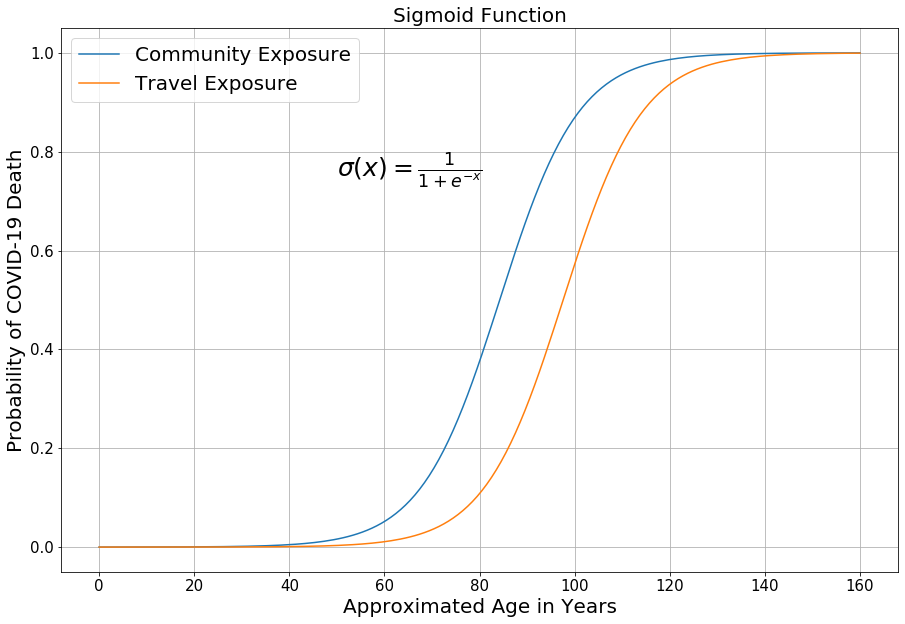

In [21]:
# plot the Sigmoid function using the parameter coefficient estimate from the logistic regression without gender model
graph.display_sigmoid(parameters)